##Mount Drive and load imports

In [152]:
from google.colab import drive
drive.mount('/drive')

#driveDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/USPollenDataset/"
driveDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/PollenVsNotPollen/"


#labelsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/classes.txt"
labelsDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/binaryClasses.txt"

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist 
import pylab as pl 
from scipy import ndimage
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

from skimage import data, util, filters, color
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import imutils


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


##Pollen Preprocessing Class

In [2]:
class PollenPreprocessing():
    def __init__(self):
        self.image = None
        self.mask = None
        self.centers = None
    

    def readImg(self,dir):
        startImg = cv2.imread(dir)
        self.image = np.array(startImg)
        return self.image

    def showImg(self,image):
        imgCopy = image
        plt.imshow(imgCopy)
        plt.show()

    def resizeImg(self,image,ratio=4):
        l = image.shape[0]
        w = image.shape[1]
        return cv2.resize(image,(w*ratio,w*ratio),interpolation = cv2.INTER_CUBIC)

    def cropImg(self,img,size=20):
        top = size
        bot = img.shape[0]-size
        left = size
        right = img.shape[1] -size
        crop_img = img[top:bot,left:right]
        return crop_img

    def getRects(self,image,size = (64,64)):
        newImg = copy.copy(image)
        length = newImg.shape[0]
        width = newImg.shape[1]
        rects = []
        x1 = 0
        y1 = 0
        #Top down 
        while y1 + size[1] < length:
            while x1 + size[0] < width:
                x2 = x1+size[0]
                y2 = y1+size[1]
                rects.append(newImg[y1:y2,x1:x2].copy())
                x1 = x2
            y1 = y2
            x1 = 0

        return np.array(rects)

    def reduceBackgroundNoise(self,img,lowThresh=35,highThresh=130,smallestArea = 75,largestArea = 10000):
        #Convert to grey Img and make histograms based on color
        
        
        greyImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        #erosion + propagation
        opened_mask = ndimage.binary_erosion(greyImg)
        closed_mask = ndimage.binary_propagation(opened_mask, mask=greyImg)

        #masks
        gran_mask = opened_mask-greyImg
        morphGrad_mask = greyImg - closed_mask

        maskIn = gran_mask-morphGrad_mask

        filtdat  =  ndimage.median_filter ( maskIn,size = 17)
        hi_dat = np.histogram(img ,bins = np.arange( 256 ))
        hi_filtdat = np.histogram(filtdat ,bins = np.arange( 256 ))

        #Color thresholds from median_filter
        void = filtdat <= lowThresh
        pollen = np.logical_and(filtdat > lowThresh,filtdat<highThresh)
        over = filtdat > highThresh
        #Hot encode thresholds
        phases  =  void . astype ( np . int )  +  2 * pollen . astype ( np . int )  +  3 * over . astype ( np . int )

        #Create mask for just values in pollen range
        pollen_op  =  ndimage . binary_opening ( pollen ,  iterations = 5 )
        pollen_labels ,  pollen_nb  =  ndimage . label ( pollen_op )
        pollen_areas = np . array ( ndimage . sum ( pollen_op , pollen_labels , np . arange ( pollen_labels . max () + .1 ))) 
        mask = np.logical_or(pollen_areas < smallestArea,pollen_areas>largestArea)
        remove_non_pollen = mask [ pollen_labels.ravel()] . reshape ( pollen_labels . shape )

        #replace all non pollen with background color (most common pixel value)
        img_temp = copy.copy(img)
        unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
        img_temp[remove_non_pollen] = unique[np.argmax(counts)]
        return img_temp

    #Run for optimal k value
    def kMeansElbowTest(self,maxK,HSV = True):
        if self.image.any() != None:
            if HSV:
                img = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                img=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)

            vectorized = img.reshape((-1,3))
            vectorized = np.float32(vectorized)

            #the below line of code defines the criteria for the algorithm to stop running,  
            #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)  
            #becomes 85% 
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
            distortions = [] 

            K = range(1,maxK)
              
            for k in K: 
                # then perform k-means clustering wit h number of clusters defined as 3 
                #also random centres are initally chosed for k-means clustering 
                retval, labels, self.centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)     
                distortions.append(sum(np.min(cdist(vectorized, self.centers,'euclidean'),axis=1)) / vectorized.shape[0]) 
                

            plt.plot(K, distortions, 'bx-') 
            plt.xlabel('Values of K') 
            plt.ylabel('Distortion') 
            plt.title('The Elbow Method using Distortion') 
            plt.show() 
        else:
            print("No Image Loaded")

    def kMeans(self,k,HSV = True):
        if self.image.any() != None:
            if HSV:
                img = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                img=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)

            vectorized = img.reshape((-1,3))
            vectorized = np.float32(vectorized)

            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) 
            # then perform k-means clustering wit h number of clusters defined as 3 
            #also random centres are initally chosed for k-means clustering 
            retval, labels, self.centers = cv2.kmeans(vectorized, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            # convert data into 8-bit values 
            self.centers = np.uint8(self.centers) 
            segmented_data = self.centers[labels.flatten()] 
              
            # reshape data into the original image dimensions 
            self.mask = segmented_data.reshape((self.image.shape)) 

            #Plot result during testing phase
            plt.imshow(self.mask)
            plt.title('Final'), plt.xticks([]), plt.yticks([])
            plt.show()
        else:
             print("No Image Loaded")

        
    def threshold(self,low,high,HSV = True):
        if self.image.any() != None:
            if HSV:
                self.image = cv2.cvtColor(self.image,cv2.COLOR_BGR2HSV)
            else:
                self.image=cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)
        
            # Define lower and uppper limits of what we call "brown"
            brown_lo=np.array(low)
            brown_hi=np.array(high)

            # Mask image to only select browns
            mask=cv2.inRange(self.image,brown_lo,brown_hi)
            self.image[mask>0] = self.centers[-1] #last in center array is largest group in kmeans ... background color

            #Convert back to BGR 
            if HSV:
                self.image = cv2.cvtColor(self.image,cv2.COLOR_HSV2BGR)
            else:
                self.image=cv2.cvtColor(self.image,cv2.COLOR_RGB2BGR)

            plt.imshow(self.image)
            plt.show()
        else:
            print("No Image Loaded")
        





    

##Image Segmentation on Microscope image

1. Decrease spatial variation of the image using erosion and dilation operators using the origional image as the mask

2. Median blur Image intensity histogram

3. Split into 3 classes based on local minima of the histogram

4. opening and closing and size thresholding on shapes

5. post processing watershed 

To try:

A. Apply granulometric filter (opened version - image) to segement bright images

B. Apply morphological gradient operation (opened version - closed image) to extract connected shapes by thresholding

C. Use SIFT for invarient feature transform


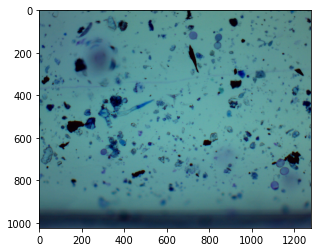

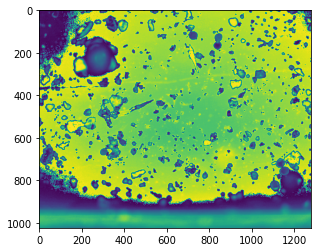

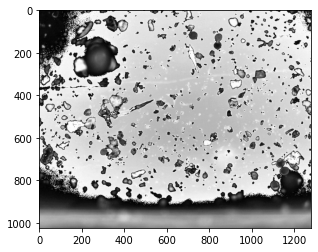

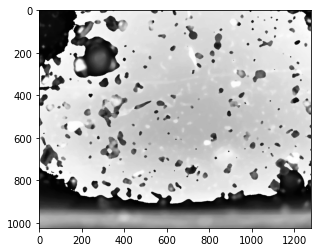

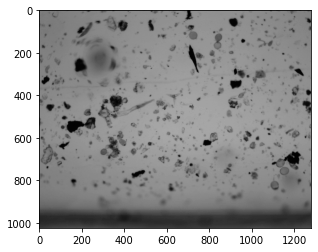

In [164]:
dDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/"
imgDir = dDir+"MicroscopeImagesandVideos/test2.jpg"

poll = PollenPreprocessing()
img = poll.readImg(imgDir)

plt.imshow(img)
plt.show()

#1

greyImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Open Close
#opened_mask = ndimage.binary_opening(greyImg)
#closed_mask = ndimage.binary_closing(greyImg)

#erosion + propagation
opened_mask = ndimage.binary_erosion(greyImg)
closed_mask = ndimage.binary_propagation(opened_mask, mask=greyImg)

#masks
gran_mask = opened_mask-greyImg
morphGrad_mask = greyImg - closed_mask

maskIn = gran_mask-morphGrad_mask


plt.imshow(maskIn)
plt.show()





#2
filtdat  =  ndimage.median_filter ( maskIn,size = 15)
hi_dat = np.histogram(img ,bins = np.arange( 256 ))
hi_filtdat = np.histogram(filtdat ,bins = np.arange( 256 ))

#poll.showImg(img)
plt.imshow(filtdat, cmap="gray", vmin=0, vmax=255)
plt.show()



plt.imshow(greyImg, cmap="gray", vmin=0, vmax=255)
plt.show()



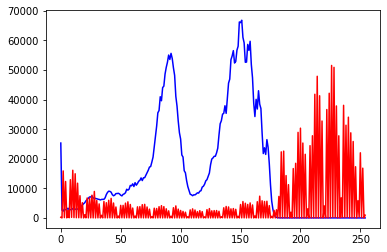

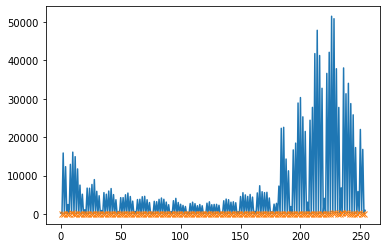

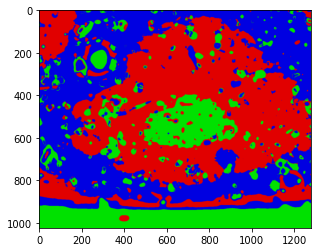

In [159]:
#3
plt.plot(hi_dat[1][:-1],hi_dat[0],color = 'blue')
plt.plot(hi_filtdat[1][:-1],hi_filtdat[0],color = 'red')
plt.show()


void = filtdat <= 40
pollen = np.logical_and(filtdat > 40,filtdat<190)
over = filtdat > 190
phases  =  void . astype ( np . int )  +  2 * pollen . astype ( np . int )  +  3 * over . astype ( np . int )

copyImg = copy.copy(img)

copyImg[phases>2]=[0,0,225]
copyImg[phases<2] = [225,0,0]
for i,val in enumerate(phases):
    for j,val2 in enumerate(val):
        if val2 == 2:
            copyImg[i][j]  = [0,225,0]
plt.imshow(copyImg)
plt.show()




In [ ]:
pollen_op  =  ndimage . binary_opening ( pollen ,  iterations = 3 )
pollen_labels ,  pollen_nb  =  ndimage . label ( pollen_op )
pollen_areas = np . array ( ndimage . sum ( pollen_op , pollen_labels , np . arange ( pollen_labels . max () + .1 ))) 
mask = np.logical_or(pollen_areas < 450,pollen_areas>10000)
remove_non_pollen = mask [ pollen_labels.ravel()] . reshape ( pollen_labels . shape )

img_temp = copy.copy(img)
unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
img_temp[remove_non_pollen] = unique[np.argmax(counts)]

plt.imshow(cv2.cvtColor(img_temp,cv2.COLOR_BGR2RGB))
plt.show()

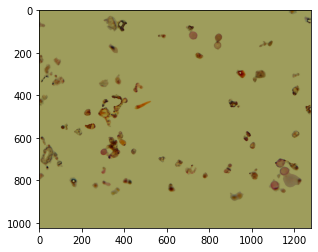

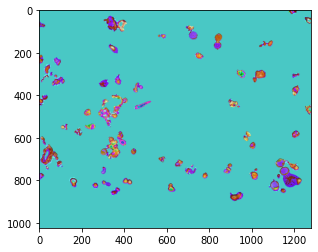

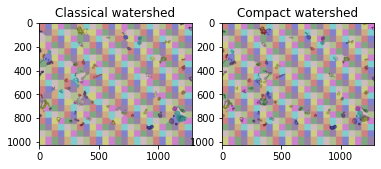

In [160]:
pollen_op  =  ndimage . binary_opening ( pollen ,  iterations = 3 )
pollen_labels ,  pollen_nb  =  ndimage . label ( pollen_op )
pollen_areas = np . array ( ndimage . sum ( pollen_op , pollen_labels , np . arange ( pollen_labels . max () + .1 ))) 
mask = np.logical_or(pollen_areas < 500,pollen_areas>10000)
remove_non_pollen = mask [ pollen_labels.ravel()] . reshape ( pollen_labels . shape )

img_temp = copy.copy(img)
unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
img_temp[remove_non_pollen] = unique[np.argmax(counts)]

plt.imshow(cv2.cvtColor(img_temp,cv2.COLOR_BGR2RGB))
plt.show()

#erosion + propagation
opened_mask = ndimage.binary_erosion(img_temp)
closed_mask = ndimage.binary_propagation(opened_mask, mask=img_temp)

#masks
gran_mask = opened_mask-img_temp
morphGrad_mask = img_temp - closed_mask

maskIn = gran_mask-morphGrad_mask

plt.imshow(maskIn)
plt.show()

greyMask = cv2.cvtColor(maskIn,cv2.COLOR_BGR2GRAY)

edges = filters.sobel(greyMask)
grid = util.regular_grid(greyMask.shape, n_points=468)

seeds = np.zeros(greyMask.shape, dtype=int)
seeds[grid] = np.arange(seeds[grid].size).reshape(seeds[grid].shape) + 1

w0 = watershed(edges, seeds)
w1 = watershed(edges, seeds, compactness=0.01)

fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(color.label2rgb(w0, greyMask, bg_label=-1))
ax0.set_title('Classical watershed')

ax1.imshow(color.label2rgb(w1, greyMask, bg_label=-1))
ax1.set_title('Compact watershed')

plt.show()


##Sliding Window

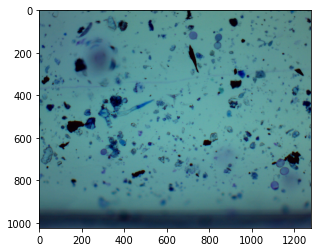

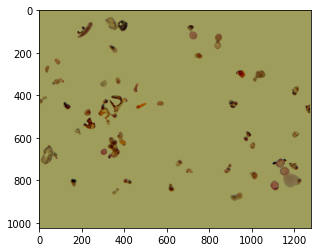

In [180]:
dDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/"
imgDir = dDir+"MicroscopeImagesandVideos/test2.jpg"

poll = PollenPreprocessing()
img = poll.readImg(imgDir)

plt.imshow(img)
plt.show()

ehh = cv2.cvtColor(poll.reduceBackgroundNoise(img,lowThresh=25,highThresh=120,smallestArea=450,largestArea=10000),cv2.COLOR_BGR2RGB)
plt.imshow(ehh)
plt.show()

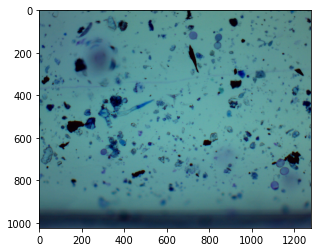

In [184]:
dDir = "../drive/My Drive/Colab Notebooks/PollenImageClassification/"
imgDir = dDir+"MicroscopeImagesandVideos/test2.jpg"

poll = PollenPreprocessing()
img = poll.readImg(imgDir)

plt.imshow(img)
plt.show()


image = poll.resizeImg(img,4)
size = (192,192)
image = poll.reduceBackgroundNoise(image,lowThresh=25,highThresh=120,smallestArea=2000,largestArea=40000)

newImg = copy.copy(image)
length = newImg.shape[0]
width = newImg.shape[1]
rects = []
x1 = 0
y1 = 0

#half step sliding window
x3 = int(size[0]/2)
y3 = int(size[1]/2)

#Top down 
while y1 + size[1] < length and y3 + size[1] < length:
    while x1 + size[0] < width and x3 + size[0] < width:
        x2 = x1+size[0]
        y2 = y1+size[1]
        rects.append(newImg[y1:y2,x1:x2])
        x1 = x2

        x4 = x3+size[0]
        y4 = y3+size[1]
        rects.append(newImg[y3:y4,x3:x4])
        x3 = x4
    y1 = y2
    x1 = 0
    y3 = y4
    x3 = 0
rects = np.array(rects)


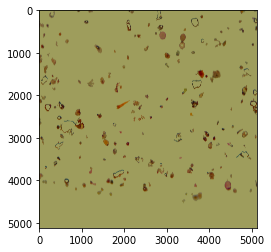

In [185]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
for img in rects:
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

##Mix

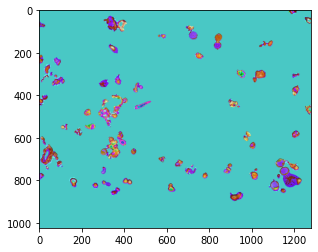

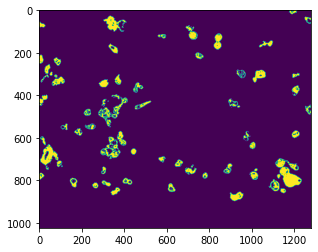

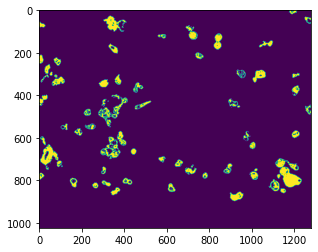

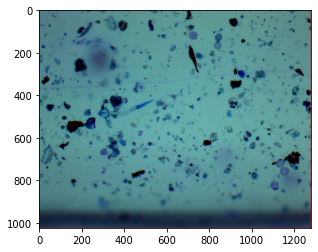

In [162]:
#erosion + propagation
opened_mask = ndimage.binary_erosion(img_temp)
closed_mask = ndimage.binary_propagation(opened_mask, mask=img_temp)

#masks
gran_mask = opened_mask-img_temp
morphGrad_mask = img_temp - closed_mask

maskIn = gran_mask-morphGrad_mask

plt.imshow(maskIn)
plt.show()



gray = cv2.cvtColor(maskIn,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh)
plt.show()

# noise removal
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)



# Finding sure foreground area
sure_fg = cv2.erode(opening,kernel,iterations=3)
plt.imshow(sure_fg)
plt.show()

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(img)
plt.show()

##CV2 Watershed

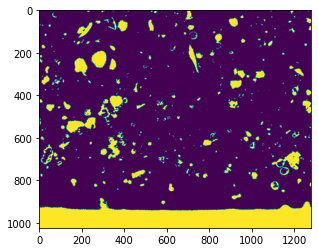

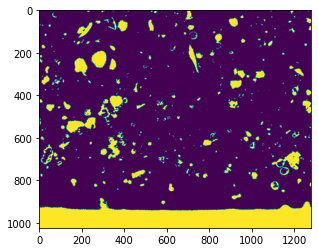

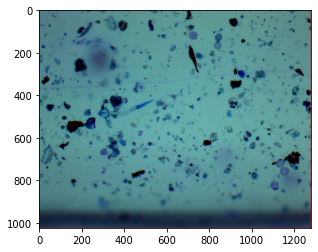

In [161]:

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh)
plt.show()

# noise removal
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)



# Finding sure foreground area
sure_fg = cv2.erode(opening,kernel,iterations=3)
plt.imshow(sure_fg)
plt.show()

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.imshow(img)
plt.show()